In [2]:
import imports
import split, model, weights, train

In [3]:
import numpy as np

X = np.load("input/X.npy")
y = np.load("input/y.npy")

print(X.shape)  # (N, 90, 1)
print(y.shape)  # (N,)


(36543, 90, 1)
(36543,)


In [4]:
X_train, X_val, X_test, y_train, y_val, y_test = split.stratified_split(X, y)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (23387, 90, 1) (23387,)
Val:   (5847, 90, 1) (5847,)
Test:  (7309, 90, 1) (7309,)


In [5]:
print("Train class distribution:", np.bincount(y_train.astype(int)))
print("Val class distribution:", np.bincount(y_val.astype(int)))
print("Test class distribution:", np.bincount(y_test.astype(int)))


Train class distribution: [23053   334]
Val class distribution: [5764   83]
Test class distribution: [7205  104]


In [28]:
print(y_train.shape)

(23387,)


In [6]:
class_weights = weights.compute_class_weights(y_train)
print(class_weights)

{np.float32(0.0): np.float64(0.5072441764629333), np.float32(1.0): np.float64(35.01047904191617)}


In [7]:
class_weights = {
    int(k): float(v)
    for k, v in class_weights.items()
}

print(class_weights)
# Mistakes on positive samples are penalized ~35x more

{0: 0.5072441764629333, 1: 35.01047904191617}


In [8]:
import importlib
import model
importlib.reload(model)

<module 'model' from '/home/jupyter-22wh1a12a2/major_project/RNA/model.py'>

In [12]:
from model import build_model, compile_model

model1 = build_model()
model1 = compile_model(model1)

model1.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 90, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 90, 32)    │        128 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 90, 32)    │        192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 90, 32)    │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 90, 96)    │          0 │ conv1d_3[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_4[0][0],   │
│                     │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 45, 96)    │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     41,216 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,017 (179.75 KB)

 Trainable params: 46,017 (179.75 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = train.train_model(model1, X_train, y_train, X_val, y_val)

Epoch 1/200
730/731 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6821 - pr_auc: 0.0193 - precision_1: 0.0149 - recall_1: 0.2616 - roc_auc: 0.5291
Epoch 1: val_pr_auc improved from None to 0.06446, saving model to output/rna.keras

Epoch 1: finished saving model to output/rna.keras
731/731 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - loss: 0.6628 - pr_auc: 0.0334 - precision_1: 0.0242 - recall_1: 0.4461 - roc_auc: 0.6439 - val_loss: 0.5233 - val_pr_auc: 0.0645 - val_precision_1: 0.0639 - val_recall_1: 0.5783 - val_roc_auc: 0.7301 - learning_rate: 0.0010
Epoch 2/200
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6074 - pr_auc: 0.0737 - precision_1: 0.0539 - recall_1: 0.6605 - roc_auc: 0.7519
Epoch 2: val_pr_auc improved from 0.06446 to 0.07208, saving model to output/rna.keras

Epoch 2: finished saving model to output/rna.keras
731/731 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - loss: 0.5688 - pr_auc: 0.0639 - precision_1: 0.0459 - recall_1: 0.6916 - roc_auc: 0.7738 - val_loss: 0.4038 - val_pr_auc:

In [15]:
results = model1.evaluate(X_test, y_test, verbose=0, return_dict=True)
print(results)

{'loss': 0.21134576201438904, 'pr_auc': 0.5888040065765381, 'precision_1': 0.1304347813129425, 'recall_1': 0.8942307829856873, 'roc_auc': 0.9658884406089783}


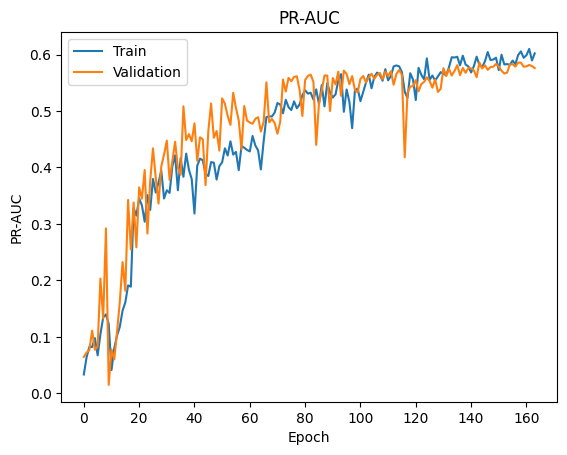

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['pr_auc'])
plt.plot(history.history['val_pr_auc'])
plt.title('PR-AUC')
plt.xlabel('Epoch')
plt.ylabel('PR-AUC')
plt.legend(['Train', 'Validation'])
plt.show()


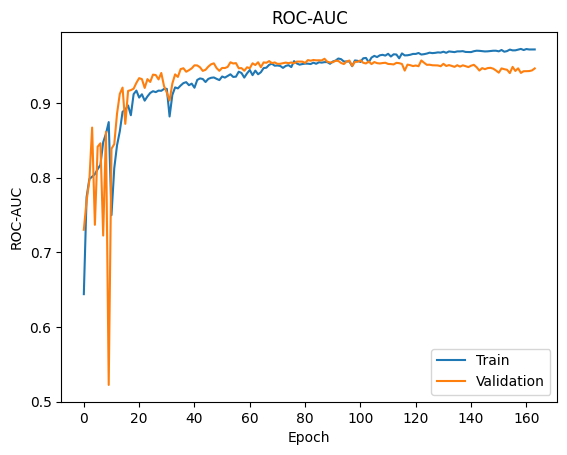

In [17]:
plt.plot(history.history['roc_auc'])
plt.plot(history.history['val_roc_auc'])
plt.title('ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.legend(['Train', 'Validation'])
plt.show()


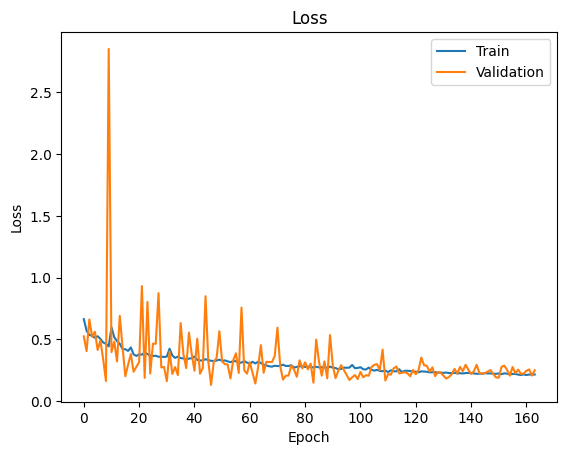

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


In [20]:
from tensorflow.keras.models import load_model
import numpy as np

model_path = "output/rna.keras"  
model1 = load_model(model_path)
predictions = model1.predict(X_test)  
predictions = predictions.flatten()    

predicted_labels = (predictions > 0.5).astype(int)
y_true = y_test.flatten().astype(int)

accuracy = (predicted_labels == y_true).mean()
print("Test Accuracy:", accuracy)


229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Test Accuracy: 0.9136680804487618
